### Aplicación de propensity score matching



In [27]:
##Borrar datos del entorno
rm(list=ls())

In [28]:
#Directorio de trabajo
setwd("C:/Users/claud/Documents/GitHub/proyecto_simi")

In [29]:
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse,janitor,MatchIt,cobalt)

#### 1. Se cargan los datos tanto de la colonia Simi como de las colonias "similares" y 
Se crea una dummy para identificar a qué grupo pertenece cada observación. Estos datos son a nivel manzana y corresponden a 67 colonias, considerando la colonia Lomas de San Carlos. La fuente de información es el Censo de Población y Vivienda 2020.

In [30]:
#Cargar datos
datos_colonias<-openxlsx::read.xlsx("G:/Mi unidad/proyecto_simi/indicadores_mza_col.xlsx",sheet=2)%>%
#Crea dummy para identificar si la manzana pertenece a colonia simi o no
mutate(simi=case_when(colonia=="Lomas de San Carlos" ~ 1,
                        TRUE ~ 0))
str(datos_colonias)

'data.frame':	2904 obs. of  39 variables:
 $ cvegeo         : chr  "0900500010258020" "0900500010258035" "0900500010258009" "0900500012574009" ...
 $ cve_col        : chr  "09005_0019" "09005_0019" "09005_0019" "09005_0019" ...
 $ id_col         : num  17240 17240 17240 17240 17240 ...
 $ colonia        : chr  "Benito Juarez" "Benito Juarez" "Benito Juarez" "Benito Juarez" ...
 $ cve_ent        : chr  "09" "09" "09" "09" ...
 $ nom_ent        : chr  "Ciudad de México" "Ciudad de México" "Ciudad de México" "Ciudad de México" ...
 $ cve_mun        : chr  "005" "005" "005" "005" ...
 $ nom_mun        : chr  "Gustavo A. Madero" "Gustavo A. Madero" "Gustavo A. Madero" "Gustavo A. Madero" ...
 $ pobtot         : num  141 147 329 260 117 124 185 119 70 129 ...
 $ hogjef_f       : num  30 27 56 31 24 12 32 22 10 9 ...
 $ hogjef_m       : num  20 19 33 37 13 21 16 15 10 29 ...
 $ graproes       : num  8.91 9.19 8.75 8.44 8.34 ...
 $ pea            : num  77 68 155 117 50 58 87 63 39 56 ...
 $ p

In [31]:
#Contar unos y ceros de la dummy
datos_colonias%>%
    count(simi)

simi,n
<dbl>,<int>
0,2851
1,53


#### 2. Se utilizan datos de marginación. 
Se busca con ello unir los datos de marginación a nivel colonia con los datos de las manzanas de las colonias seleccionadas. Es importante mencionar que si bien los datos de marginación son a nivel colonia, se asume que, a nivel manzana, son homogéneos. La idea es utilizar el índice de marginación como variable de interés para estimar el efecto del tratamiento.

In [32]:
#Se descargan datos de marginación de CONAPO


url_conapo="http://www.conapo.gob.mx/work/models/CONAPO/Marginacion/Datos_Abiertos/Colonia/IMC_2020.zip"

download.file(url_conapo, destfile = "data/IMC_2020.zip")

unzip("data/IMC_2020.zip", exdir = "data/IMC_2020")


In [33]:
#Se leen los datos y se filtra para CDMX y EdoMex
datos_marginacion<-openxlsx::read.xlsx("data/IMC_2020/IMUC_2020.xlsx",sheet=1, 
                                        startRow = 4)%>%
janitor::clean_names()%>%
filter(cve_ent=="09" | cve_ent=="15")%>%
select(cve_col,imn_2020)

In [34]:
#Se unen los datos de marginación a los de las manzanas de las colonias seleccionadas
datos_colonias<-datos_colonias%>%
left_join(datos_marginacion, by=c("cve_col"="cve_col"))
datos_colonias

cvegeo,cve_col,id_col,colonia,cve_ent,nom_ent,cve_mun,nom_mun,pobtot,hogjef_f,⋯,pct_sinagua,pct_tinaco,pct_cister,pct_celular,pct_internet,pct_computadora,pct_tv_paga,pct_videos,simi,imn_2020
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0900500010258020,09005_0019,17240,Benito Juarez,09,Ciudad de México,005,Gustavo A. Madero,141,30,⋯,0.00000,88.67925,22.641509,79.24528,71.69811,33.96226,32.07547,18.867925,0,0.9519898
0900500010258035,09005_0019,17240,Benito Juarez,09,Ciudad de México,005,Gustavo A. Madero,147,27,⋯,0.00000,97.82609,6.521739,60.86957,47.82609,30.43478,21.73913,15.217391,0,0.9519898
0900500010258009,09005_0019,17240,Benito Juarez,09,Ciudad de México,005,Gustavo A. Madero,329,56,⋯,0.00000,78.26087,18.478261,80.43478,59.78261,33.69565,34.78261,22.826087,0,0.9519898
0900500012574009,09005_0019,17240,Benito Juarez,09,Ciudad de México,005,Gustavo A. Madero,260,31,⋯,0.00000,74.64789,14.084507,84.50704,50.70423,39.43662,21.12676,8.450704,0,0.9519898
0900500010258019,09005_0019,17240,Benito Juarez,09,Ciudad de México,005,Gustavo A. Madero,117,24,⋯,0.00000,92.10526,0.000000,57.89474,57.89474,31.57895,10.52632,0.000000,0,0.9519898
0900500012574010,09005_0019,17240,Benito Juarez,09,Ciudad de México,005,Gustavo A. Madero,124,12,⋯,0.00000,83.33333,25.000000,77.77778,58.33333,38.88889,41.66667,13.888889,0,0.9519898
0900500010258001,09005_0019,17240,Benito Juarez,09,Ciudad de México,005,Gustavo A. Madero,185,32,⋯,0.00000,84.00000,28.000000,88.00000,58.00000,44.00000,46.00000,24.000000,0,0.9519898
0900500010258045,09005_0019,17240,Benito Juarez,09,Ciudad de México,005,Gustavo A. Madero,119,22,⋯,0.00000,92.50000,0.000000,65.00000,62.50000,30.00000,32.50000,15.000000,0,0.9519898
0900500010258002,09005_0019,17240,Benito Juarez,09,Ciudad de México,005,Gustavo A. Madero,70,10,⋯,0.00000,95.00000,0.000000,90.00000,45.00000,40.00000,25.00000,0.000000,0,0.9519898


## Modelos
#### 3. Se ajusta un **modelo probit** para obtener el propensity score

In [35]:
var_modelo <- simi ~ hogjef_f + hogjef_m + graproes + pea +  
              pe_inac + pocupada + pdesocup + pob0_14 + pob15_64 + pob65_mas

In [36]:
#Modelo probit
modelo_probit<-glm(var_modelo,
                     data=datos_colonias,family=binomial(link="probit"))
summary(modelo_probit)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Call:
glm(formula = var_modelo, family = binomial(link = "probit"), 
    data = datos_colonias)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.169468   0.257440  -8.427  < 2e-16 ***
hogjef_f    -0.001087   0.017018  -0.064   0.9491    
hogjef_m     0.025554   0.014405   1.774   0.0761 .  
graproes     0.031545   0.027659   1.141   0.2541    
pea         -0.076610   0.091018  -0.842   0.4000    
pe_inac     -0.042467   0.024924  -1.704   0.0884 .  
pocupada     0.015783   0.086878   0.182   0.8558    
pdesocup    -0.113903   0.090695  -1.256   0.2092    
pob0_14      0.042366   0.010148   4.175 2.98e-05 ***
pob15_64     0.036525   0.025738   1.419   0.1559    
pob65_mas    0.029846   0.026386   1.131   0.2580    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 529.4  on 2903  degrees of freedom
Residual deviance: 488.1  on 2893  degrees of freedom
AIC: 5

#### 3.1 Se obtiene el propensity score y se realiza el matching

In [37]:
prs_df <- data.frame(pr_score = predict(modelo_probit, type = "response"),
                     simi = datos_colonias$simi)

In [38]:
matchit_out <- matchit(var_modelo,
                       data = datos_colonias, method = "nearest", distance = prs_df$pr_score)
matchit_out
summary(matchit_out)

A matchit object
 - method: 1:1 nearest neighbor matching without replacement
 - distance: User-defined
 - number of obs.: 2904 (original), 106 (matched)
 - target estimand: ATT
 - covariates: hogjef_f, hogjef_m, graproes, pea, pe_inac, pocupada, pdesocup, pob0_14, pob15_64, pob65_mas


Call:
matchit(formula = var_modelo, data = datos_colonias, method = "nearest", 
    distance = prs_df$pr_score)

Summary of Balance for All Data:
          Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean
distance         0.0324        0.0180          0.7269     1.2374    0.2526
hogjef_f         8.5094       11.5735         -0.4175     0.4303    0.0384
hogjef_m        18.9057       21.4749         -0.1908     0.4903    0.0250
graproes         9.2647        9.3526         -0.0922     0.1762    0.0774
pea             50.1698       64.0702         -0.3729     0.4419    0.0523
pe_inac         31.4151       37.8050         -0.2764     0.5315    0.0385
pocupada        49.3774       62.6086         -0.3607     0.4454    0.0505
pdesocup         0.2642        0.9670         -0.7293     0.1935    0.0247
pob0_14         27.6604       28.7106         -0.0478     0.7419    0.0220
pob15_64        70.1698       86.4963         -0.3130     0.5063    0.0505
pob65_mas        6.1132     

In [39]:
#Crear tabla con matcheados y el score de propensión
datos_matcheados<-match.data(matchit_out)
print(paste("Número de manzanas matcheadas:",nrow(datos_matcheados)))
#Número de manzanas matcheadas sin considerar Lomas de San Carlos
print(paste("Número de manzanas matcheadas sin considerar Lomas de San Carlos:",nrow(datos_matcheados[datos_matcheados$simi==0,])))
datos_matcheados

[1] "Número de manzanas matcheadas: 106"
[1] "Número de manzanas matcheadas sin considerar Lomas de San Carlos: 53"


,cvegeo,cve_col,id_col,colonia,cve_ent,nom_ent,cve_mun,nom_mun,pobtot,hogjef_f,⋯,pct_celular,pct_internet,pct_computadora,pct_tv_paga,pct_videos,simi,imn_2020,distance,weights,subclass
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
10,0900500012574038,09005_0019,17240,Benito Juarez,09,Ciudad de México,005,Gustavo A. Madero,129,9,⋯,84.61538,43.58974,25.64103,15.384615,7.692308,0,0.9519898,0.048198757,1,10
17,0900500010258015,09005_0019,17240,Benito Juarez,09,Ciudad de México,005,Gustavo A. Madero,105,13,⋯,81.48148,74.07407,44.44444,18.518519,22.222222,0,0.9519898,0.025630934,1,2
140,0900700014838009,09007_0013,17473,Ampliacion Emiliano Zapata,09,Ciudad de México,007,Iztapalapa,117,11,⋯,90.00000,76.66667,26.66667,23.333333,26.666667,0,0.9476954,0.043328905,1,27
174,0900700012189005,09007_0051,17512,El Rosario,09,Ciudad de México,007,Iztapalapa,77,7,⋯,80.76923,69.23077,30.76923,26.923077,19.230769,0,0.9548266,0.010332922,1,47
220,0900700012051095,09007_0056,17517,El Triangulo,09,Ciudad de México,007,Iztapalapa,88,8,⋯,96.00000,48.00000,16.00000,0.000000,0.000000,0,0.9397610,0.026139155,1,3
284,0900700014289028,09007_0167,17628,San Francisco Apolocalco,09,Ciudad de México,007,Iztapalapa,147,10,⋯,71.05263,63.15789,36.84211,26.315789,18.421053,0,0.9410142,0.041723277,1,24
320,0900700014293012,09007_0167,17628,San Francisco Apolocalco,09,Ciudad de México,007,Iztapalapa,145,7,⋯,73.80952,66.66667,28.57143,28.571429,0.000000,0,0.9410142,0.051061547,1,12
476,090080001057A028,09008_0007,17695,El Ocotal,09,Ciudad de México,008,La Magdalena Contreras,154,11,⋯,86.66667,77.77778,35.55556,26.666667,11.111111,0,0.9463932,0.071366383,1,32
712,0901700010899014,09017_0043,18749,Merced Balbuena,09,Ciudad de México,017,Venustiano Carranza,60,6,⋯,80.00000,80.00000,75.00000,45.000000,45.000000,0,0.9407663,0.031424306,1,37


To identify the units, use first mouse button; to stop, use second.


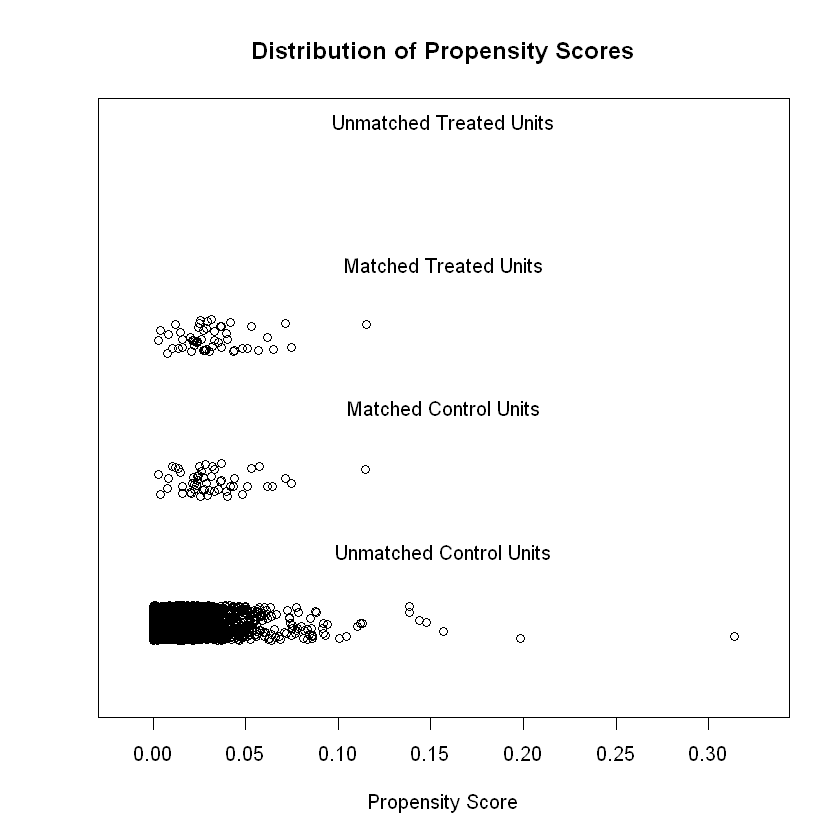

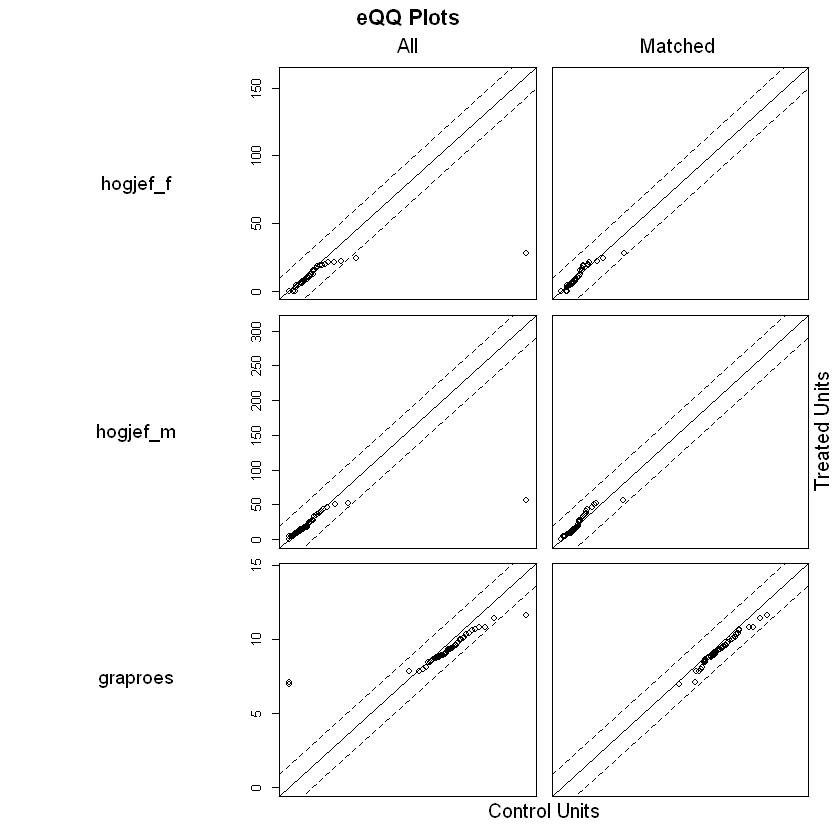

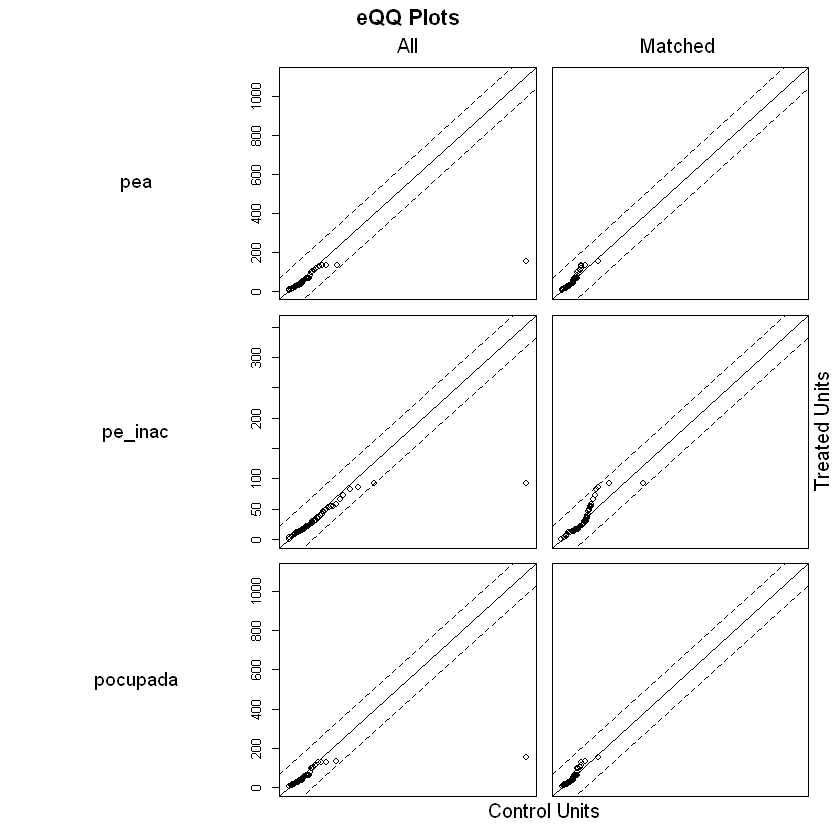

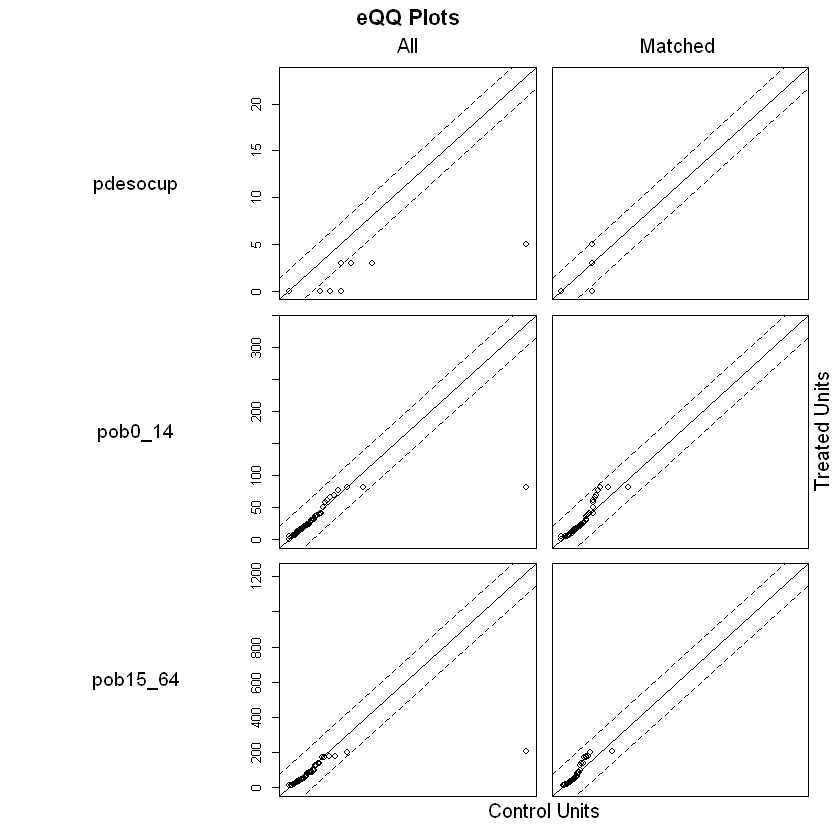

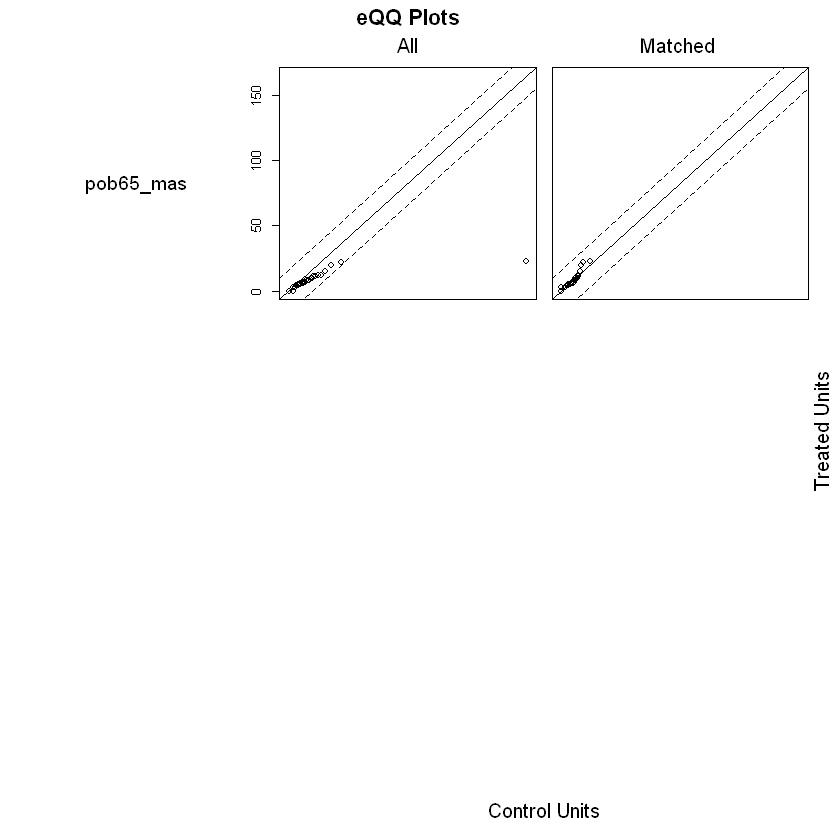

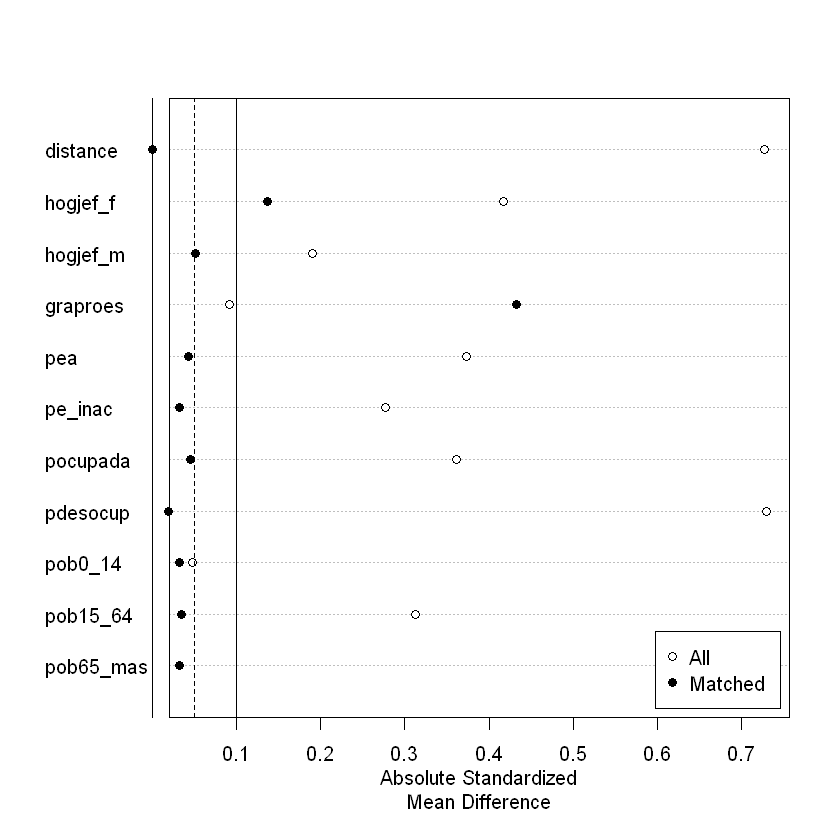

In [40]:
plot(matchit_out, type = "jitter")
plot(matchit_out, type = "qq")
plot(summary(matchit_out))


#### 3.3 Se estima el efecto del tratamiento

In [41]:
t.test(imn_2020~simi, data=datos_matcheados)


	Welch Two Sample t-test

data:  imn_2020 by simi
t = 4.6062, df = 52, p-value = 2.686e-05
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 0.001603732 0.004079649
sample estimates:
mean in group 0 mean in group 1 
      0.9460781       0.9432364 


#### 4.1 Se estima ***modelo logit** para obtener el propensity score

In [42]:
modelo_logit<-glm(var_modelo,
                        data=datos_colonias,family=binomial(link="logit"))
summary(modelo_logit)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Call:
glm(formula = var_modelo, family = binomial(link = "logit"), 
    data = datos_colonias)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.104618   0.631493  -6.500 8.04e-11 ***
hogjef_f    -0.000985   0.041689  -0.024   0.9811    
hogjef_m     0.057572   0.033809   1.703   0.0886 .  
graproes     0.072038   0.067621   1.065   0.2867    
pea         -0.193690   0.218278  -0.887   0.3749    
pe_inac     -0.109612   0.059647  -1.838   0.0661 .  
pocupada     0.040800   0.208319   0.196   0.8447    
pdesocup    -0.277124   0.224704  -1.233   0.2175    
pob0_14      0.097968   0.023327   4.200 2.67e-05 ***
pob15_64     0.097028   0.061757   1.571   0.1162    
pob65_mas    0.075359   0.063004   1.196   0.2317    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 529.40  on 2903  degrees of freedom
Residual deviance: 489.35  on 2893  degrees of freedom
AIC: 

In [43]:
prs_df <- data.frame(pr_score = predict(modelo_logit, type = "response"),
                     simi = datos_colonias$simi)

In [44]:
matchit_out <- matchit(var_modelo,
                       data = datos_colonias, method = "nearest", distance = prs_df$pr_score)
matchit_out
summary(matchit_out)

A matchit object
 - method: 1:1 nearest neighbor matching without replacement
 - distance: User-defined
 - number of obs.: 2904 (original), 106 (matched)
 - target estimand: ATT
 - covariates: hogjef_f, hogjef_m, graproes, pea, pe_inac, pocupada, pdesocup, pob0_14, pob15_64, pob65_mas


Call:
matchit(formula = var_modelo, data = datos_colonias, method = "nearest", 
    distance = prs_df$pr_score)

Summary of Balance for All Data:
          Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean
distance         0.0320        0.0180          0.6804     1.3482    0.2494
hogjef_f         8.5094       11.5735         -0.4175     0.4303    0.0384
hogjef_m        18.9057       21.4749         -0.1908     0.4903    0.0250
graproes         9.2647        9.3526         -0.0922     0.1762    0.0774
pea             50.1698       64.0702         -0.3729     0.4419    0.0523
pe_inac         31.4151       37.8050         -0.2764     0.5315    0.0385
pocupada        49.3774       62.6086         -0.3607     0.4454    0.0505
pdesocup         0.2642        0.9670         -0.7293     0.1935    0.0247
pob0_14         27.6604       28.7106         -0.0478     0.7419    0.0220
pob15_64        70.1698       86.4963         -0.3130     0.5063    0.0505
pob65_mas        6.1132     

In [45]:
datos_matcheados<-match.data(matchit_out)
print(paste("Número de manzanas matcheadas:",nrow(datos_matcheados)))
#Número de manzanas matcheadas sin considerar Lomas de San Carlos
print(paste("Número de manzanas matcheadas sin considerar Lomas de San Carlos:",nrow(datos_matcheados[datos_matcheados$simi==0,])))
datos_matcheados

[1] "Número de manzanas matcheadas: 106"
[1] "Número de manzanas matcheadas sin considerar Lomas de San Carlos: 53"


,cvegeo,cve_col,id_col,colonia,cve_ent,nom_ent,cve_mun,nom_mun,pobtot,hogjef_f,⋯,pct_celular,pct_internet,pct_computadora,pct_tv_paga,pct_videos,simi,imn_2020,distance,weights,subclass
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
136,0900700015037017,09007_0013,17473,Ampliacion Emiliano Zapata,09,Ciudad de México,007,Iztapalapa,160,9,⋯,78.00000,44.00000,20.00000,8.00000,6.000000,0,0.9476954,0.032881102,1,14
160,0900700012206013,09007_0051,17512,El Rosario,09,Ciudad de México,007,Iztapalapa,23,0,⋯,100.00000,85.71429,57.14286,0.00000,0.000000,0,0.9548266,0.024079667,1,23
193,0900700012174015,09007_0051,17512,El Rosario,09,Ciudad de México,007,Iztapalapa,86,18,⋯,80.55556,66.66667,47.22222,22.22222,27.777778,0,0.9548266,0.008479839,1,51
197,0900700012174003,09007_0051,17512,El Rosario,09,Ciudad de México,007,Iztapalapa,70,0,⋯,83.33333,61.11111,50.00000,38.88889,0.000000,0,0.9548266,0.022630622,1,15
214,0900700012174018,09007_0051,17512,El Rosario,09,Ciudad de México,007,Iztapalapa,136,12,⋯,83.33333,64.28571,64.28571,42.85714,23.809524,0,0.9548266,0.003164353,1,38
229,0900700012051087,09007_0056,17517,El Triangulo,09,Ciudad de México,007,Iztapalapa,69,9,⋯,79.16667,29.16667,12.50000,0.00000,0.000000,0,0.9397610,0.028338405,1,35
234,0900700012051114,09007_0056,17517,El Triangulo,09,Ciudad de México,007,Iztapalapa,77,14,⋯,88.88889,22.22222,0.00000,18.51852,14.814815,0,0.9397610,0.024077291,1,28
244,0900700012051108,09007_0056,17517,El Triangulo,09,Ciudad de México,007,Iztapalapa,65,6,⋯,100.00000,42.85714,28.57143,28.57143,0.000000,0,0.9397610,0.039300592,1,33
319,0900700014293013,09007_0167,17628,San Francisco Apolocalco,09,Ciudad de México,007,Iztapalapa,119,5,⋯,72.72727,42.42424,24.24242,24.24242,9.090909,0,0.9410142,0.053718436,1,39


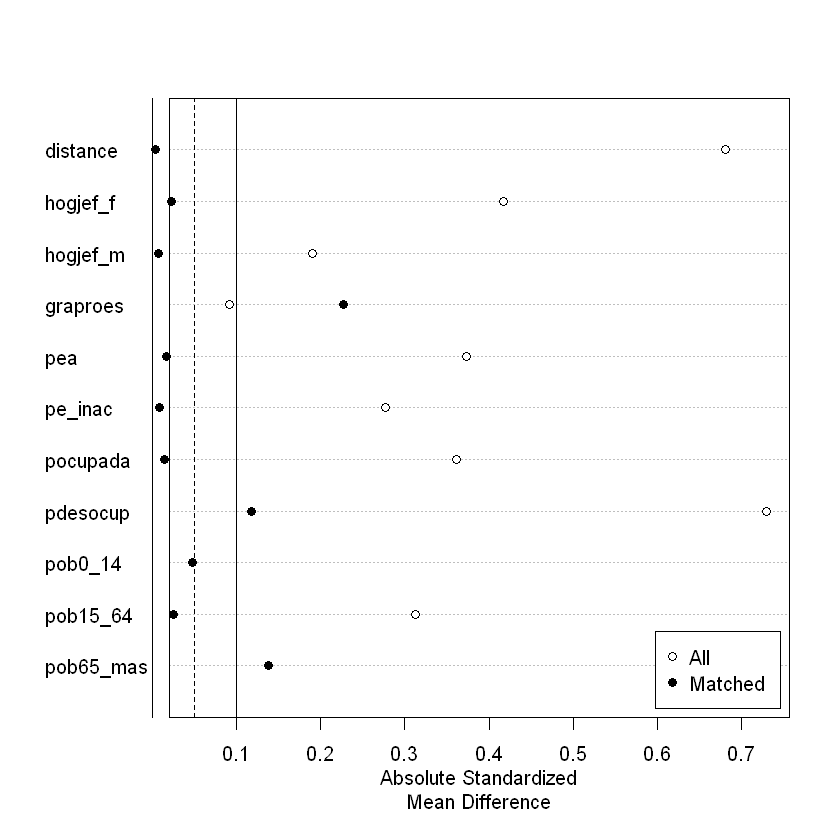

In [46]:
plot(summary(matchit_out))

#### 4.2 Se estima el efecto del tratamiento

In [47]:
t.test(imn_2020~simi, data=datos_matcheados)


	Welch Two Sample t-test

data:  imn_2020 by simi
t = 4.2456, df = 52, p-value = 9.022e-05
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 0.001441988 0.004026782
sample estimates:
mean in group 0 mean in group 1 
      0.9459708       0.9432364 
